### Ash clouds model
We would like to model the dynamics of an ash clouds model from the reference paper. The model of the Ash clouds paper is of the form: 
$$
\begin{aligned}
dx &= u dt \\
du &= - \frac{\partial V}{\partial x} (x,u) dt - \lambda(x) u dt + \sigma(x) dW
\end{aligned}
$$
Importantly, one need to define the potential of interest: 
$$
V(X,U) = - \frac{1}{2} \left[ \sigma_U^2(X) + U^2 \log\left(\frac{\sigma^2_U(X)}{\sigma_U^2(X_{ref})}\right)\right]
$$

And the importantly, we define  that are used in the potential: 

$$
\sigma_U(X) = \kappa_\sigma u_* \left(1-\frac{X}{H}\right)^{\frac{3}{4}}, 
$$
with $\kappa_\sigma = 1.3$ and $u_*=0.2 m/s$. 

We also define: 
$$
\tau(X) = \kappa_\tau \frac{X}{\sigma_U(X)},
$$
with $\kappa_\tau = 0.5$ and 
$$
\sigma(X) = \sqrt{\frac{2 \sigma_U^2(X)}{\tau(X)}} \\
\rightarrow \sigma(X) = \sqrt{\frac{2 \sigma_U^3(X)}{\kappa_\tau X}}
$$
and we also have: 
$$
\lambda(X) = 1/\tau(X)
$$

Importantly, we also need to look at the term: 
$$
\frac{\partial V(X,U)}{\partial X} = - \sigma'_U(X) \left[\sigma_U(X) + \frac{U^2}{\sigma_U(X)} \right]
$$

as well as this term: 
$$
\sigma'_U(X)=\frac{-3 \kappa_\sigma u_* }{4H} \left( 1- \frac{X}{H}\right)^{-1/4}.
$$

Both the function $\sigma_U(X)$ and $\tau(X)$ requires regularisation for numerical stability purpose: 

$$
    \sigma_U(X)= 
\begin{cases}
    \sigma_U(\epsilon_{reg}),& \text{if } X < \epsilon_{reg}\\
    \sigma_U(H-\epsilon_{reg}),& \text{if } X\geq H- \epsilon_{reg}
\end{cases}
$$

and 

$$
\tau(X)= 
\begin{cases}
    \tau(\epsilon_{reg}),& \text{if } X < \epsilon_{reg}\\
    \tau(H-\epsilon_{reg}),& \text{if } X\geq H- \epsilon_{reg}
\end{cases}
$$

Those conditions results in the derivative of $\sigma_U(X)$ as: 
$$
\sigma'_U(X)= 0 \text{ if } X < \epsilon_{reg} \text{ or } X\geq H- \epsilon_{reg}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Define the regularisation constants

And the importantly, we define  that are used in the potential: 

$$
\sigma_U(X) = \kappa_\sigma u_* \left(1-\frac{X}{H}\right)^{\frac{3}{4}}, 
$$
with $\kappa_\sigma = 1.3$ and $u_*=0.2 m/s$. 

We also define: 
$$
\tau(X) = \kappa_\tau \frac{X}{\sigma_U(X)},
$$
with $\kappa_\tau = 0.5$ and finally : 
and we also have: 
$$
\lambda(X) = 1/\tau(X)
$$

Both the function $\sigma_U(X)$ and $\tau(X)$ requires regularisation for numerical stability purpose: 

$$
    \sigma_U(X)= 
\begin{cases}
    \sigma_U(\epsilon_{reg}),& \text{if } X < \epsilon_{reg}\\
    \sigma_U(H-\epsilon_{reg}),& \text{if } X\geq H- \epsilon_{reg}
\end{cases}
$$

and 

$$
\tau(X)= 
\begin{cases}
    \tau(\epsilon_{reg}),& \text{if } X < \epsilon_{reg}\\
    \tau(H-\epsilon_{reg}),& \text{if } X\geq H- \epsilon_{reg}
\end{cases}
$$

In [2]:
## CODE the function of interest 
def sigmaU(X,H):
    kappa_sigma = 1.3
    ustar=0.2
    sigmaU = kappa_sigma*ustar*np.power((1-X/H),3/4)
    eps=0.1
    sigmaU_eps = kappa_sigma*ustar*np.power(1-eps/H,3/4)
    sigmaU_Heps = kappa_sigma*ustar*np.power(1-(H-eps)/H,3/4)
    final_s = (X<eps)*sigmaU_eps+(X>(H-eps))*sigmaU_Heps+ (X<=(H-eps))*(X>=eps)*sigmaU
    return final_s

def sigmaUprime(X,H):
    kappa_sigma = 1.3
    ustar=0.2
    sigmaUprimeX = (-3*kappa_sigma*ustar)/(4*H)*np.power((1-X/H),-1/4)
    eps=0.1
    final_v = (X<eps)*0+(X>(H-eps))*0+ (X<=(H-eps))*(X>=eps)*sigmaUprimeX
    return final_v

## CODE the function of interest 
def lambda_U(X,H):
    kappa_tau=0.5
    tau = kappa_tau*X/sigmaU(X,H) 
    eps=0.1
    tau_eps= kappa_tau*eps/sigmaU(eps,H) 
    tau_Heps = kappa_tau*(H-eps)/sigmaU(H-eps,H) 
    final_t = (X<eps)*tau_eps+(X>(H-eps))*tau_Heps+ (X<=(H-eps))*(X>=eps)*tau
    return 1/final_t

def sigma(X,H):
    re=np.sqrt(2*np.power(sigmaU(X,H),2)*lambda_U(X,H))
    return re


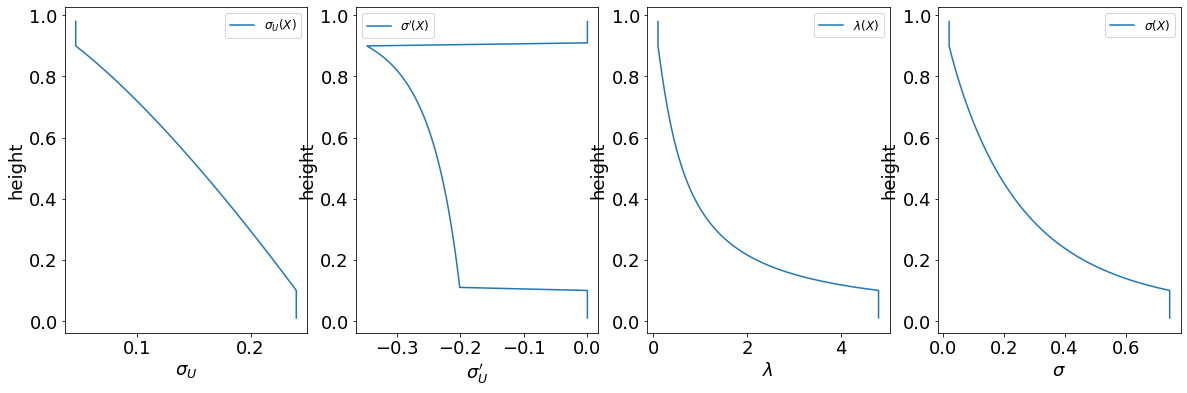

In [3]:
X=np.arange(0.01,0.99,0.01)

fig, (ax1,ax2,ax3,ax4)= plt.subplots(1, 4,figsize=(20,6))# plt.figure(figsize=(4,4))
ax1.plot(sigmaU(X,1),X,label="$\\sigma_U(X)$")
ax1.set_ylabel("height")
ax1.set_xlabel("$\\sigma_U$")
ax1.legend()

ax2.plot(sigmaUprime(X,1),X,label="$\\sigma'(X)$")
ax2.set_ylabel("height")
ax2.set_xlabel("$\\sigma_U'$")
ax2.legend()

ax3.plot(lambda_U(X,1),X,label="$\\lambda(X)$")
ax3.set_ylabel("height")
ax3.set_xlabel("$\\lambda$")
ax3.legend()

ax4.plot(sigma(X,1),X,label="$\\sigma(X)$")
ax4.set_ylabel("height")
ax4.set_xlabel("$\\sigma$")
ax4.legend()



We can now plot the potential!

Importantly, one need to define the potential of interest: 
$$
V(X,U) = - \frac{1}{2} \left[ \sigma_U^2(X) + U^2 \log\left(\frac{\sigma^2_U(X)}{\sigma_U^2(X_{ref})}\right)\right]
$$

Importantly, we also need to look at the term: 
$$
\frac{\partial V(X,U)}{\partial X} = - \sigma'_U(X) \left[\sigma_U(X) + \frac{U^2}{\sigma_U(X)} \right]
$$


In [4]:
def pot(X,U,H,Xref):
    sigmaUX = sigmaU(X,H)
    sigmaUX2 = sigmaUX*sigmaUX
    sigmaUXref = sigmaU(Xref,H)
    sigmaUXref2 = sigmaUXref*sigmaUXref
    re = -0.5*(sigmaUX2+U*U*np.log(sigmaUX2/sigmaUXref2))
    return re

def nablaV(X,U,H):
    sigmaUX = sigmaU(X,H)
    re = - sigmaUprime(X,H)*(sigmaU(X,H)+U*U/sigmaUX)
    return re
    

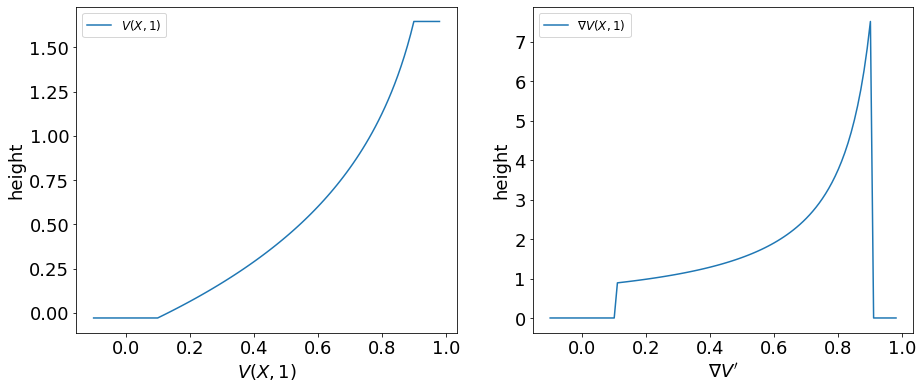

In [5]:
X=np.arange(-0.1,0.99,0.01)

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(15,6))# plt.figure(figsize=(4,4))
ax1.plot(X,pot(X,1,1,0.1),label="$V(X,1)$")
ax1.set_ylabel("height")
ax1.set_xlabel("$V(X,1)$")
ax1.legend()

ax2.plot(X,nablaV(X,1,1),label="$\\nabla V(X,1)$")
ax2.set_ylabel("height")
ax2.set_xlabel("$\\nabla V'$")
ax2.legend()

# ax3.plot(lambda_U(X,1),X,label="$\\lambda(X)$")
# ax3.set_ylabel("height")
# ax3.set_xlabel("$\\lambda$")
# ax3.legend()

# ax4.plot(sigma(X,1),X,label="$\\sigma(X)$")
# ax4.set_ylabel("height")
# ax4.set_xlabel("$\\sigma$")
# ax4.legend()


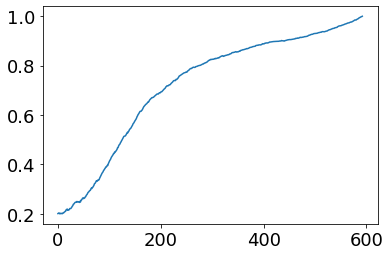

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time


@njit(float64(float64,float64))
def sigmaU(X,H):
    kappa_sigma = 1.3
    ustar=0.2
    sigmaU = kappa_sigma*ustar*np.power((1-X/H),3/4)
    eps=0.1
    sigmaU_eps = kappa_sigma*ustar*np.power(1-eps/H,3/4)
    sigmaU_Heps = kappa_sigma*ustar*np.power(1-(H-eps)/H,3/4)
    final_s = (X<eps)*sigmaU_eps+(X>(H-eps))*sigmaU_Heps+ (X<=(H-eps))*(X>=eps)*sigmaU
    return final_s

@njit(float64(float64,float64))
def sigmaUprime(X,H):
    kappa_sigma = 1.3
    ustar=0.2
    sigmaUprimeX = (-3*kappa_sigma*ustar)/(4*H)*np.power((1-X/H),-1/4)
    eps=0.1
    final_v = (X<eps)*0+(X>(H-eps))*0+ (X<=(H-eps))*(X>=eps)*sigmaUprimeX
    return final_v


@njit(float64(float64,float64))
def nablaV(X,U):
    H=1
    sigmaUX = sigmaU(X,H)
    re = - sigmaUprime(X,H)*(sigmaU(X,H)+U*U/sigmaUX)
    return re

@njit(float64(float64,float64))
def lambda_U(X,H):
    kappa_tau=0.5
    tau = kappa_tau*X/sigmaU(X,H) 
    eps=0.1
    tau_eps= kappa_tau*eps/sigmaU(eps,H) 
    tau_Heps = kappa_tau*(H-eps)/sigmaU(H-eps,H) 
    final_t = (X<eps)*tau_eps+(X>(H-eps))*tau_Heps+ (X<=(H-eps))*(X>=eps)*tau
    return 1/final_t

@njit(float64(float64,float64,float64[:]))
def g(X,h,dtbounds):
    return 1

@njit(float64[:](float64[:],float64,float64[:]))
def A_ada(qp,h,dtbounds):
    q=qp[0]
    p=qp[1]
    gq = qp[2]
    ## fixed point method for g((qn+1+qn)/2)
    g_half = g(q+0.5*h*p*gq,h,dtbounds)
    g_half = g(q+0.5*h*p*g_half,h,dtbounds)
    g_half = g(q+0.5*h*p*g_half,h,dtbounds)
    g_half = g(q+0.5*h*p*g_half,h,dtbounds)
    gq = g_half
    q = q+p*gq*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64,float64[:],float64))
def B_ada(qp,n,h,dtbounds,H):
    q=qp[0]
    p=qp[1]
    gq=g(q,h,dtbounds)
    sigmaUq=sigmaU(q,1)
    sigmaUq2=sigmaUq*sigmaUq
    p = sigmaUq2*np.tan((n+1)*h*np.abs(gq)*np.abs(sigmaUq))
    p=(q<=0)*-p+(q>=H)*-p+(q>=0)*(q<=H)*p
    qp_gq=np.array([q,p,gq])
    return (qp_gq)
# B_ada(np.array([0.0,1.1]),1,0.1,np.array([0.0,0.1]),1)


@njit(float64[:](float64[:],float64,float64[:],float64))
def O_ada(qp,h,dtbounds,H):
    q=qp[0]
    p=qp[1]
    dB = np.random.normal(0,1,1)[0]
    gq=g(q,h,dtbounds)
    lambdap=lambda_U(q,H)
    alpha =np.exp(-lambdap*h*gq)
    sigmaUq=sigmaU(q,H)
    s = sigmaUq*sigmaU(q,H)/(2*lambdap)
    p = alpha*p+ np.sqrt((1-alpha*alpha)*s)*dB
    qp_gq=np.array([q,p,gq])
    return (qp_gq)

@njit(float64[:](float64[:],float64,float64,float64[:],float64))
def one_traj_ada(qp,T,h,dtbounds,H):
    t=0
    h_half=h/2
    tcount=0
    while t<T:
        tcount=tcount+1
        qp_gq=B_ada(qp,tcount,h_half,dtbounds,H)
        qp=A_ada(qp_gq,h_half,dtbounds)
        qp_gq=O_ada(qp,h_half,dtbounds,H)
        qp=A_ada(qp_gq,h_half,dtbounds)
        qp_gq=B_ada(qp,tcount,h_half,dtbounds,H)
        qp=qp_gq[:2]
        gq=qp_gq[2]
        t=np.round(t+gq*h,7)
    qp_t=np.append(qp,tcount)
    return (qp_t)
    

@njit(parallel=True)
def method_baoab_ada2(n_samples,T,H,h,dtbounds):
    qpt_list=np.zeros((n_samples,3))
    qipi = np.array([0.5,0.5]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(n_samples):
        qfpftf = one_traj_ada(qipi,T,h,dtbounds,H)
        qpt_list[j,::]=qfpftf
    return(qpt_list)

# #compile the method
# qpt_list=method_baoab_ada2(1,10,1.0,0.1,np.array([0.01,0.1]))
# print(qpt_list)
n_samples=1
T=200
h=0.1
dtbounds=np.array([0.1,0.1])
H=1
# qpt_list=np.zeros((n_samples,3))
qipi = np.array([0.5,0.5]) #np.random.normal(0,1,2) #initial conditions
t=0
h_half=h/2
tcount=0
qp = np.array([0.2,0.2]) #np.random.normal(0,1,2) #initial conditions
qp_t1=[]
while t<T:
    tcount=tcount+1
    qp_gq=B_ada(qp,tcount,h_half,dtbounds,H)
    qp=A_ada(qp_gq,h_half,dtbounds)
    qp_gq=O_ada(qp,h_half,dtbounds,H)
    qp=A_ada(qp_gq,h_half,dtbounds)
    qp_gq=B_ada(qp,tcount,h_half,dtbounds,H)
    # qp=qp_gq[:2]
    # gq=qp_gq[2]
    t=np.round(t+gq*h,7)
    # print(t)
    qp_t1.append(qp)

plt.plot(np.array(qp_t1)[::,0])
plt.show()


(2000, 2)

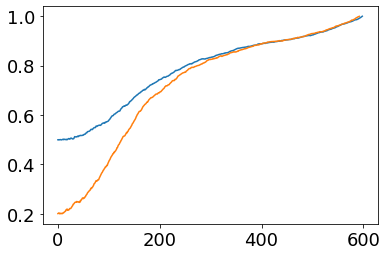

In [164]:
plt.plot(np.array(qp_t)[::,0])
plt.plot(np.array(qp_t1)[::,0])

np.shape(qp_t1)

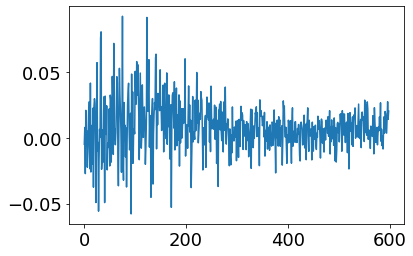

In [154]:
plt.plot(np.array(qp_t)[::,1])


In [125]:
np.array(qp_t)[::,0]

array([0.50184294, 0.50207039, 0.50324592, 0.50306762, 0.50026553,
       0.49836708, 0.49917692, 0.49936453, 0.49708055, 0.49503897])

we have

$$

L_1^{\dagger} u = \nabla_p \cdot (p u) + \beta^{-1} \Delta_p u
$$
(the second term is self adjoint)

Note that $\rho_{\beta} = \exp(-\beta p^2/2)  \exp(-\beta U(q))$

i.e. it separates. $ L_1$ and its adjoint only involves differential operations in the momenta, so 
$$
 L_1^{\dagger} \rho_{\beta} = \exp(-\beta U(q)) L_1^{\dagger} \exp(-\beta p^2/2)
$$
and
$$
\Delta_p = \nabla \cdot \nabla 
$$
so
$$
\Delta_p \exp(-\beta p^2/2) = \nabla \cdot [\nabla  \exp(-\beta p^2/2)] = - \nabla \cdot [\beta p \exp(-\beta p^2/2)]
$$
thus 
$$
 \beta^{-1} \Delta_p  \exp(-\beta p^2/2) = - \nabla \cdot [ p \exp(-\beta p^2/2)]
$$